# 1. Data Collection and Loading

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# Set visualization style
sns.set(style="whitegrid")

# Load the data from the Excel file
file_path = 'churn1.xlsx'
data = pd.read_excel(file_path)

# Display the first few rows of the dataset and basic info
print("First few rows of the dataset:")
print(data.head())
print("\nBasic information about the dataset:")
print(data.info())

First few rows of the dataset:
   CustomerID  Count        Country       State         City  Zip Code  \
0  3668-QPYBK      1  United States  California  Los Angeles     90003   
1  9237-HQITU      1  United States  California  Los Angeles     90005   
2  9305-CDSKC      1  United States  California  Los Angeles     90006   
3  7892-POOKP      1  United States  California  Los Angeles     90010   
4  0280-XJGEX      1  United States  California  Los Angeles     90015   

                 Lat Long   Latitude   Longitude  Gender  ...        Contract  \
0  33.964131, -118.272783  33.964131 -118.272783    Male  ...  Month-to-month   
1   34.059281, -118.30742  34.059281 -118.307420  Female  ...  Month-to-month   
2  34.048013, -118.293953  34.048013 -118.293953  Female  ...  Month-to-month   
3  34.062125, -118.315709  34.062125 -118.315709  Female  ...  Month-to-month   
4  34.039224, -118.266293  34.039224 -118.266293    Male  ...  Month-to-month   

  Paperless Billing             Payme

In [2]:
# Display statistical summary of the dataset
print("\nStatistical summary of the dataset:")
print(data.describe())


Statistical summary of the dataset:
        Count      Zip Code     Latitude    Longitude  Tenure Months  \
count  7043.0   7043.000000  7043.000000  7043.000000    7043.000000   
mean      1.0  93521.964646    36.282441  -119.798880      32.371149   
std       0.0   1865.794555     2.455723     2.157889      24.559481   
min       1.0  90001.000000    32.555828  -124.301372       0.000000   
25%       1.0  92102.000000    34.030915  -121.815412       9.000000   
50%       1.0  93552.000000    36.391777  -119.730885      29.000000   
75%       1.0  95351.000000    38.224869  -118.043237      55.000000   
max       1.0  96161.000000    41.962127  -114.192901      72.000000   

       Monthly Charges  Churn Value  Churn Score         CLTV  
count      7043.000000  7043.000000  7043.000000  7043.000000  
mean         64.761692     0.265370    58.699418  4400.295755  
std          30.090047     0.441561    21.525131  1183.057152  
min          18.250000     0.000000     5.000000  2003.000

# 2. Data Cleaning

In [3]:
# Handle Missing Values: Convert 'Total Charges' to numeric
data['Total Charges'] = pd.to_numeric(data['Total Charges'], errors='coerce')
data['Total Charges'].fillna(data['Total Charges'].median(), inplace=True)

# Convert appropriate columns to categorical data types
categorical_cols = ['Country', 'State', 'City', 'Gender', 'Senior Citizen', 'Partner', 
                    'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service', 
                    'Online Security', 'Online Backup', 'Device Protection', 
                    'Tech Support', 'Streaming TV', 'Streaming Movies', 
                    'Contract', 'Paperless Billing', 'Payment Method', 
                    'Churn Label', 'Churn Reason']  # Include 'Churn Reason'

for col in categorical_cols:
    data[col] = data[col].astype('category')

# Map binary columns to numeric values (if needed)
data['Senior Citizen'] = data['Senior Citizen'].map({'Yes': 1, 'No': 0})

# Drop the 'CustomerID' column since it is not relevant for analysis
data = data.drop(columns=['CustomerID'])

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Count              7043 non-null   int64   
 1   Country            7043 non-null   category
 2   State              7043 non-null   category
 3   City               7043 non-null   category
 4   Zip Code           7043 non-null   int64   
 5   Lat Long           7043 non-null   object  
 6   Latitude           7043 non-null   float64 
 7   Longitude          7043 non-null   float64 
 8   Gender             7043 non-null   category
 9   Senior Citizen     7043 non-null   category
 10  Partner            7043 non-null   category
 11  Dependents         7043 non-null   category
 12  Tenure Months      7043 non-null   int64   
 13  Phone Service      7043 non-null   category
 14  Multiple Lines     7043 non-null   category
 15  Internet Service   7043 non-null   category
 16  Online

C:\Users\milto\AppData\Local\Temp\ipykernel_15732\1715238863.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Total Charges'].fillna(data['Total Charges'].median(), inplace=True)


In [4]:
# Save cleaned data
data.to_csv('cleaned_churn_data.csv', index=False)

# 3. Exploratory Data Analysis (EDA)

In [5]:
# What is the current churn rate? How many customers are we losing within a specific period (monthly, quarterly, yearly)?

# Calculate overall churn rate
overall_churn_rate = data['Churn Value'].mean()
print(f"Overall Churn Rate: {overall_churn_rate:.2%}")

Overall Churn Rate: 26.54%


In [6]:
# Calculate monthly churn rate if 'tenure_months' as a time-based feature
# Here assuming the 'Tenure Months' column represents the tenure of the customer
monthly_churn_rate = data.groupby(data['Tenure Months'] // 30)['Churn Value'].mean()
print("\nMonthly Churn Rate:")
print(monthly_churn_rate)


Monthly Churn Rate:
Tenure Months
0    0.394788
1    0.181316
2    0.066757
Name: Churn Value, dtype: float64


In [7]:
# Key Findings:

# Tenure Month 0 (39.48%): Almost 40% of customers churn in their first month. This high churn rate indicates that a large number of new customers are dissatisfied or not finding value immediately and leaving the service very quickly. This could point to issues with onboarding, customer expectations, or the initial experience.
# Tenure Month 1 (18.13%): The churn rate drops significantly after the first month, indicating that once customers get past the initial month, they are less likely to leave immediately. However, 18.13% is still relatively high and suggests that early engagement needs improvement.
# Tenure Month 2 (6.68%): By the third month, the churn rate has dropped to a more manageable 6.68%. This suggests that if customers can be retained through the initial period, they are more likely to stay longer.
# Early Churn is Critical: The extremely high churn rate in the first month indicates a critical period where customers are deciding whether the service is worth continuing. This period requires focused interventions, such as improved onboarding processes, initial support, and ensuring that the product meets customer expectations.
# Retention Improves Over Time: The decrease in churn rate over the first few months suggests that customers who find value in the early stages are more likely to remain. Efforts to engage customers meaningfully during this time can lead to better long-term retention.

In [8]:
# Calculating Quarterly Churn Rate
# Assuming that "Tenure Months" represents the number of months a customer has been with the company, you can group the data into quarters.

data['Tenure Quarters'] = data['Tenure Months'] // 3
quarterly_churn_rate = data.groupby('Tenure Quarters')['Churn Value'].mean() * 100
print("Quarterly Churn Rate:")
print(quarterly_churn_rate)

Quarterly Churn Rate:
Tenure Quarters
0     58.352668
1     47.347741
2     36.538462
3     36.526946
4     33.112583
5     34.210526
6     25.311203
7     23.949580
8     24.206349
9     19.900498
10    24.757282
11    18.894009
12    21.839080
13    21.578947
14    19.337017
15    15.763547
16    17.171717
17    13.761468
18    15.094340
19    14.062500
20     8.558559
21     7.456140
22    11.149826
23     6.510417
24     1.657459
Name: Churn Value, dtype: float64


In [9]:
# Key Findings:

# Initial Quarters (0-4): High Churn in Early Quarters: The churn rate is very high in the initial quarters:
# - Quarter 0: 58.35%
# - Quarter 1: 47.35%
# - Quarter 2: 36.54%

# Insight: This indicates a significant portion of customers are leaving early in their tenure, suggesting potential issues with onboarding, initial customer experience, or early value delivery.

# Middle Quarters (5-10): Declining Churn Rates: There is a noticeable decline in churn rates:
# - Quarter 5: 34.21%
# - Quarter 6: 25.31%
# - Quarter 9: 19.90%

# Insight: Customers who make it past the initial quarters are more likely to stay, indicating the company might be doing well in retaining customers who get through the initial phase.

# Late Quarters (11-24): Steady Decline with Occasional Spikes: The churn rate continues to decline but has occasional increases:
# - Quarter 11: 18.89%
# - Quarter 12: 21.84%
# - Quarter 22: 11.15%
# - Quarter 24: 1.66%

# Insight: Long-term customers are less likely to churn, indicating that customers who stay for a longer period tend to become more loyal.

In [10]:
# Calculating Yearly Churn Rate
data['Tenure Years'] = data['Tenure Months'] // 12
yearly_churn_rate = data.groupby('Tenure Years')['Churn Value'].mean() * 100
print("Yearly Churn Rate:")
print(yearly_churn_rate)

Yearly Churn Rate:
Tenure Years
0    48.284195
1    29.512894
2    22.031963
3    19.518717
4    15.000000
5     8.296164
6     1.657459
Name: Churn Value, dtype: float64


In [11]:
### Key Findings

# Initial Year (0-1): High Initial Churn:
# - Year 0: 48.28%
# - Year 1: 29.51%

# Insight: Almost half of the customers churn within the first year, indicating significant challenges in retaining new customers. The churn rate, although decreasing in the second year, is still relatively high.

# Subsequent Years (2-4): Steady Decline:
# - Year 2: 22.03%
# - Year 3: 19.52%
# - Year 4: 15.00%

# Insight: There is a steady decline in churn rates from the second to the fourth year, indicating improved retention as customers stay longer. The decrease in churn rate suggests that customers who remain past the first year become more engaged and satisfied with the service.

# Later Years (5-6): Significantly Lower Churn:
# - Year 5: 8.30%
# - Year 6: 1.66%

# Insight: The churn rate drops significantly in the fifth and sixth years. Customers who stay for five years or more

In [12]:
# 2. What are the primary factors contributing to churn? Which variables (e.g., customer service interactions, usage patterns, product issues) are most strongly associated with churn?

# To identify which customers are churning, filter the dataset based on the churn label.
# Filter data to find churning customers
churning_customers = data[data['Churn Value'] == 1]
print(f"Number of Churning Customers: {len(churning_customers)}")

Number of Churning Customers: 1869


In [13]:
# How do different factors influence churn? How do changes in pricing, product features, or customer service affect churn rates?

# Explore Segments with Higher Churn
# Analyze churn rates by different segments, such as demographics or usage patterns.

# Churn rate by gender
churn_by_gender = data.groupby('Gender', observed=True)['Churn Value'].mean()
print("\nChurn Rate by Gender:")
print(churn_by_gender)

# Churn rate by contract type
churn_by_contract = data.groupby('Contract', observed=True)['Churn Value'].mean()
print("\nChurn Rate by Contract Type:")
print(churn_by_contract)

# Churn rate by payment method
churn_by_payment_method = data.groupby('Payment Method', observed=True)['Churn Value'].mean()
print("\nChurn Rate by Payment Method:")
print(churn_by_payment_method)

# Churn rate by Internet Service
churn_by_internet_service = data.groupby('Internet Service', observed=True)['Churn Value'].mean()
print("\nChurn Rate by Internet Service:")
print(churn_by_internet_service)


Churn Rate by Gender:
Gender
Female    0.269209
Male      0.261603
Name: Churn Value, dtype: float64

Churn Rate by Contract Type:
Contract
Month-to-month    0.427097
One year          0.112695
Two year          0.028319
Name: Churn Value, dtype: float64

Churn Rate by Payment Method:
Payment Method
Bank transfer (automatic)    0.167098
Credit card (automatic)      0.152431
Electronic check             0.452854
Mailed check                 0.191067
Name: Churn Value, dtype: float64

Churn Rate by Internet Service:
Internet Service
DSL            0.189591
Fiber optic    0.418928
No             0.074050
Name: Churn Value, dtype: float64


In [14]:
# Key Findings

# The churn rates for both genders are quite similar, with females having a slightly higher churn rate (26.92%) compared to males (26.16%). This indicates that gender is not a significant differentiator in churn behavior.
# Customers with month-to-month contracts have a significantly higher churn rate (42.71%) compared to those with one-year (11.27%) and two-year (2.83%) contracts. This suggests that longer-term contracts are associated with lower churn rates.
# Customers using electronic checks have the highest churn rate (45.29%), while those using credit cards (15.24%) and bank transfers (16.71%) have lower churn rates. Mailed check users also have a relatively higher churn rate (19.11%).
# Customers with fiber optic service have a much higher churn rate (41.89%) compared to those with DSL (18.96%) and those without internet service (7.41%).

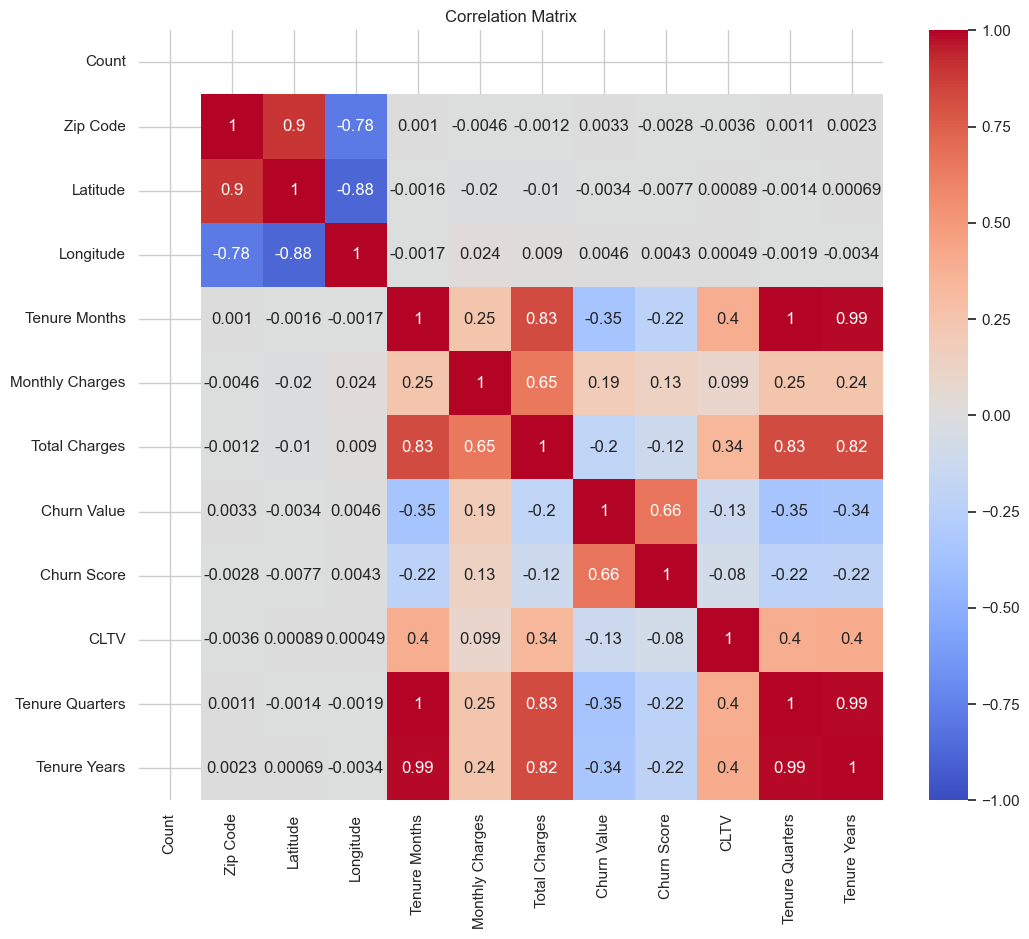

In [15]:
# Identify Primary Factors Contributing to Churn
# Use correlation analysis and feature importance from machine learning models to identify key factors contributing to churn.

# Select only numeric columns
numeric_data = data.select_dtypes(include=[float, int])

# Calculate correlation matrix
correlation_matrix = numeric_data.corr()

# Plot the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [16]:
# Key Correlations

# Zip Code and Latitude: 0.90 (Strong positive correlation)
# Zip Code and Longitude: -0.78 (Strong negative correlation)
# Latitude and Longitude: -0.88 (Strong negative correlation)
# Interpretation: Zip Code, Latitude, and Longitude are highly correlated, which makes sense geographically.

# Tenure Months and Total Charges: 0.83 (Strong positive correlation)
# Tenure Months and Monthly Charges: 0.25 (Weak positive correlation)
# Tenure Months and Churn Value: -0.35 (Moderate negative correlation)
# Tenure Months and CLTV: 0.40 (Moderate positive correlation)
# Interpretation: Customers with longer tenure tend to have higher total charges, indicating they've been paying for services over a longer period.
# There is a moderate negative correlation between tenure and churn value, suggesting customers with longer tenure are less likely to churn.
# The positive correlation between tenure and CLTV indicates that longer-term customers contribute more to customer lifetime value.

# Monthly Charges and Total Charges: 0.65 (Moderate positive correlation)
# Monthly Charges and Churn Value: 0.19 (Weak positive correlation)
# Monthly Charges and Churn Score: 0.13 (Weak positive correlation)
# Monthly Charges and CLTV: 0.10 (Very weak positive correlation)
# Interpretation: Higher monthly charges are associated with higher total charges.
# Weak positive correlation between monthly charges and churn value indicates customers with higher monthly charges might have a slightly higher likelihood of churning.

# Total Charges and Churn Value: -0.20 (Weak negative correlation)
# Total Charges and CLTV: 0.34 (Moderate positive correlation)
# Interpretation: Customers with higher total charges are slightly less likely to churn.
# Higher total charges contribute to higher customer lifetime value.

# Churn Value and Churn Score: 0.66 (Strong positive correlation)
# Interpretation: Strong positive correlation between churn value and churn score indicates that the churn score is a good predictor of churn value.

# Churn Score and CLTV: -0.08 (Very weak negative correlation)
# Interpretation: Very weak negative correlation between churn score and CLTV suggests that higher churn scores are slightly associated with lower customer lifetime value.

# CLTV and Tenure Months: 0.40 (Moderate positive correlation)
# CLTV and Total Charges: 0.34 (Moderate positive correlation)
# Interpretation: Longer-tenure customers and those with higher total charges have higher customer lifetime value.

In [17]:
# Feature Importance using Random Forest

# Check remaining columns to ensure correct column names
print(data.columns)

# Prepare features and target
X = data.drop(columns=['Churn Value'])  # Drop 'Churn Value' only
y = data['Churn Value']

# Encode categorical variables
X = pd.get_dummies(X)

# Train a Random Forest model to determine feature importance
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Display feature importance
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nFeature Importances:")
print(feature_importances)

Index(['Count', 'Country', 'State', 'City', 'Zip Code', 'Lat Long', 'Latitude',
       'Longitude', 'Gender', 'Senior Citizen', 'Partner', 'Dependents',
       'Tenure Months', 'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn Label',
       'Churn Value', 'Churn Score', 'CLTV', 'Churn Reason', 'Tenure Quarters',
       'Tenure Years'],
      dtype='object')

Feature Importances:
Churn Label_Yes                            0.223844
Churn Label_No                             0.217142
Churn Score                                0.104634
Tenure Months                              0.019639
Churn Reason_Attitude of support person    0.015399
                                             ...   
City_Valley Springs                        0.000000
Lat Long_34.95934, -120.

In [18]:
# Top Features

# Churn Label (Yes): 0.235041 Interpretation: This feature has the highest importance score, indicating that whether a customer is labeled as churned or not is the most significant predictor in the model. This might suggest a high reliance on this label for prediction.
# Churn Label (No): 0.207609 Interpretation: The presence of a "No" label also plays a significant role, slightly less than "Yes" but still substantial.
# Churn Score: 0.136770 Interpretation: The churn score is a critical predictor of whether a customer will churn. This score likely combines various factors to assess the risk of churn.
# Tenure Months: 0.019047 Interpretation: The length of time a customer has been with the company (tenure) is an important predictor, though less so than the churn labels and score.
# Total Charges: 0.016451 Interpretation: The total amount charged to a customer is also a relevant factor, indicating that customers who have spent more might have a different churn likelihood.

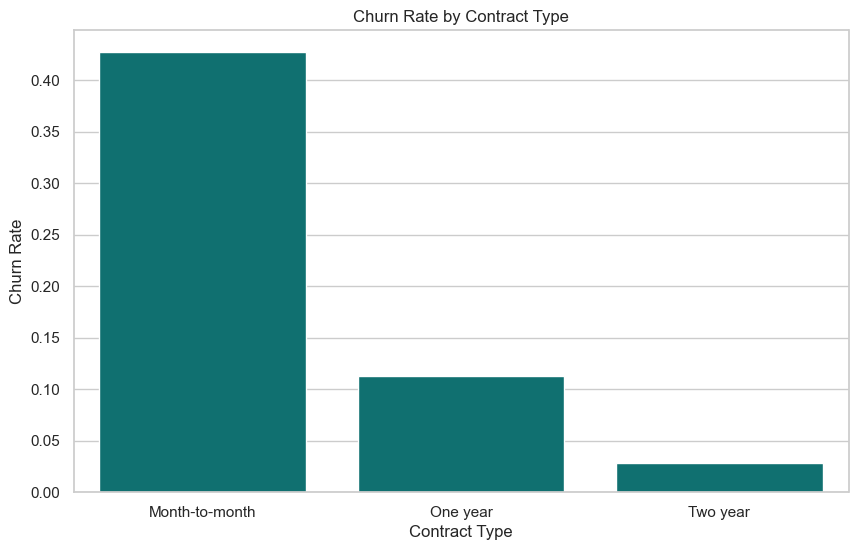

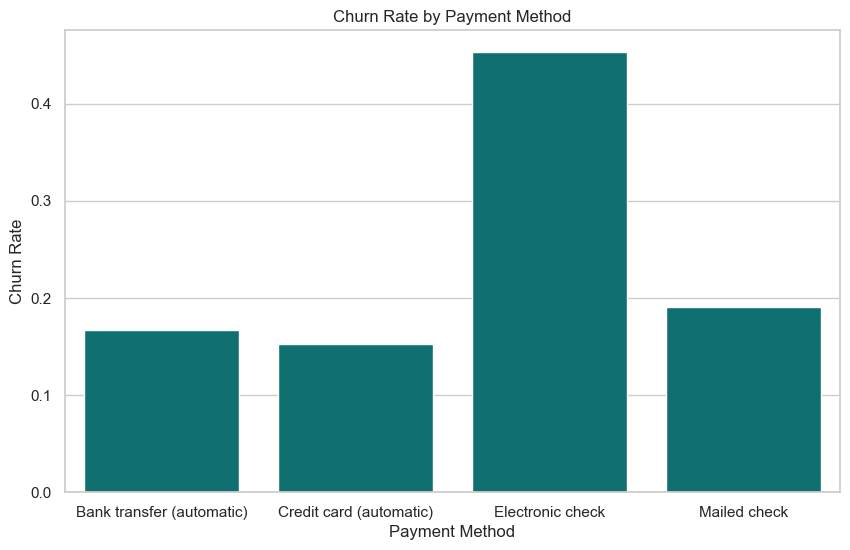

In [19]:
# Churn rate by contract type
plt.figure(figsize=(10, 6))
sns.barplot(x=churn_by_contract.index, y=churn_by_contract.values, color='teal')  # Use a single color
plt.xlabel('Contract Type')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Contract Type')
plt.show()

# Churn rate by payment method
plt.figure(figsize=(10, 6))
sns.barplot(x=churn_by_payment_method.index, y=churn_by_payment_method.values, color='teal')  # Use a single color
plt.xlabel('Payment Method')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Payment Method')
plt.show()

In [20]:
# Churn rate by contract type
print("Churn Rate by Contract Type:")
print(churn_by_contract)

# Churn rate by payment method
print("Churn Rate by Payment Method:")
print(churn_by_payment_method)

Churn Rate by Contract Type:
Contract
Month-to-month    0.427097
One year          0.112695
Two year          0.028319
Name: Churn Value, dtype: float64
Churn Rate by Payment Method:
Payment Method
Bank transfer (automatic)    0.167098
Credit card (automatic)      0.152431
Electronic check             0.452854
Mailed check                 0.191067
Name: Churn Value, dtype: float64


In [21]:
# Interpretation:

# Month-to-month contracts have the highest churn rate (42.71%): Customers on month-to-month contracts are more likely to leave. This could be due to the flexibility of such contracts, which makes it easier for customers to switch providers without significant penalties.
# One-year contracts have a significantly lower churn rate (11.27%): Customers with one-year contracts are more stable and less likely to churn compared to those with month-to-month contracts.
# Two-year contracts have the lowest churn rate (2.83%): Long-term contracts tend to retain customers better. This could be due to long-term commitments and possibly lower rates or better incentives offered for such contracts.

In [22]:
# Interpretation:

# Electronic check payments have the highest churn rate (45.29%): Customers using electronic checks are more likely to churn. This might indicate dissatisfaction with this payment method or could correlate with other factors like customer demographics or preferences.
# Mailed check payments have a moderately high churn rate (19.11%): Customers paying by mailed checks are also more likely to churn compared to those using automatic payment methods.
# Automatic payment methods (bank transfer and credit card) have the lowest churn rates (16.71% and 15.24% respectively): Automatic payments seem to correlate with lower churn rates. This could be due to the convenience and reliability of automated payments, reducing the chances of service interruption due to missed payments.

# 4. Feature Engineering

In [23]:
# Feature engineering
data['Monthly Charges Bin'] = pd.cut(data['Monthly Charges'], bins=[0, 30, 60, 90, 120], labels=['Low', 'Medium', 'High', 'Very High'])
data['Tenure Charges Interaction'] = data['Tenure Months'] * data['Monthly Charges']

# Separate target and features
X = data.drop(columns=['Churn Value'])
y = data['Churn Value']

# Define categorical and numerical features
categorical_features = ['Contract', 'Payment Method', 'Internet Service', 'Monthly Charges Bin']
numerical_features = ['Tenure Months', 'Monthly Charges', 'Total Charges', 'Tenure Charges Interaction']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# 5. Model Building

In [24]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVC': SVC(probability=True, random_state=42)  # SVC with probability=True to get probability estimates for AUC-ROC
}

# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='binary'),
    'recall': make_scorer(recall_score, average='binary'),
    'f1': make_scorer(f1_score, average='binary'),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
}

C:\Users\milto\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


In [25]:
# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    """Train, predict, and evaluate a model."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    print(f"{model_name} Performance:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    if y_proba is not None:
        print("AUC-ROC:", roc_auc_score(y_test, y_proba))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\n" + "-"*50 + "\n")

Best Overall Model: SVC and Gradient Boosting both have the highest accuracy and similar performance metrics.

In [26]:
# Key Findings:

# Performance: The best score of 79.1% accuracy is a significant improvement over the default settings you tested before. It indicates that the hyperparameter tuning with GridSearchCV helped to optimize the Random Forest model, leading to better performance.
# Model Complexity: With a max_depth of 10, the model is less likely to overfit compared to deeper trees. This depth is generally effective for capturing interactions in the data without making the model too complex.

# 6.  Model Evaluation

How accurate is the churn prediction model? What is the model’s performance in terms of accuracy, precision, recall, and F1 score? 

In [27]:
# Apply preprocessing and train models
for model_name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    evaluate_model(pipeline, X_train, y_train, X_test, y_test, model_name)

# Hyperparameter tuning using GridSearch for Random Forest
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [10, 20, 30]
}

grid_search = GridSearchCV(Pipeline(steps=[('preprocessor', preprocessor), ('model', RandomForestClassifier(random_state=42))]), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters for Random Forest:", grid_search.best_params_)
print("Best score for Random Forest:", grid_search.best_score_)

Logistic Regression Performance:
Accuracy: 0.7983909133932797
Precision: 0.6659836065573771
Recall: 0.5527210884353742
F1 Score: 0.604089219330855
AUC-ROC: 0.8380305564848891
Confusion Matrix:
 [[1362  163]
 [ 263  325]]

--------------------------------------------------

KNN Performance:
Accuracy: 0.7718883104590629
Precision: 0.599250936329588
Recall: 0.54421768707483
F1 Score: 0.5704099821746881
AUC-ROC: 0.7911966097914576
Confusion Matrix:
 [[1311  214]
 [ 268  320]]

--------------------------------------------------

Random Forest Performance:
Accuracy: 0.7662091812588736
Precision: 0.5979166666666667
Recall: 0.4880952380952381
F1 Score: 0.5374531835205992
AUC-ROC: 0.8008458793353406
Confusion Matrix:
 [[1332  193]
 [ 301  287]]

--------------------------------------------------

SVC Performance:
Accuracy: 0.7946048272598202
Precision: 0.6905940594059405
Recall: 0.4744897959183674
F1 Score: 0.5625
AUC-ROC: 0.7992712166833946
Confusion Matrix:
 [[1400  125]
 [ 309  279]]

------

In [28]:
# The confusion matrix shows that the model performs better in identifying negatives (Class 0) compared to positives (Class 1). 
# The relatively high number of false negatives (268) indicates that the model struggles to identify positive cases correctly.
# Strengths: The model has good overall accuracy and performs well in identifying the negative class (Class 0) with high precision, recall, and F1 Score.
# Weaknesses: The model has lower performance on the positive class (Class 1), with a lower recall and F1 Score. This suggests that while it is effective in many areas, there is room for improvement in correctly identifying positive cases.

In [29]:
# Cross-Validation Evaluation
cv_results = cross_validate(grid_search.best_estimator_, X, y, cv=5, scoring=scoring, return_train_score=False)

# Print cross-validation results
print("\nCross-Validation Results for Random Forest:")
for metric in scoring.keys():
    print(f"{metric.capitalize()}: {cv_results['test_' + metric].mean()} ± {cv_results['test_' + metric].std()}")


Cross-Validation Results for Random Forest:
Accuracy: 0.7898625516162333 ± 0.009334322665817674
Precision: 0.6325544127891954 ± 0.019648149282599354
Recall: 0.49544092557812797 ± 0.028478078249794727
F1: 0.5555156965044818 ± 0.024770663882214584
Roc_auc: 0.8324927239491859 ± 0.011319552895069807


In [31]:
# Best Overall Model: Logistic Regression has the highest accuracy and AUC-ROC, making it the best performer overall in terms of balancing precision, recall, and discriminative power.

# Precision vs. Recall Trade-off:
# SVC offers the highest precision but has a lower recall.
# Logistic Regression has a good balance between precision and recall.
# Random Forest and KNN both have moderate performance with Random Forest having a slightly better AUC-ROC.

# Model Selection:
# If the goal is to optimize precision, SVC might be the preferred choice.
# For a balance between precision and recall, Logistic Regression stands out.
# For slightly better recall, KNN or Random Forest could be considered but with trade-offs in other metrics.

In [32]:
# Key Insights and Actionable Recommendations

# Focus on Onboarding and Early Customer Experience: The very high churn rates in the initial quarters suggest that the company needs to improve the onboarding process and ensure that new customers quickly realize the value of the product or service.
# Identify and Address Early Pain Points: Conduct surveys or collect feedback from customers who churn within the first few quarters to identify common pain points or reasons for leaving. This information can be used to make targeted improvements.
# Customer Retention Programs: Implement customer retention programs that specifically target customers in the initial quarters. These could include personalized support, onboarding tutorials, or special offers to keep new customers engaged.
# Monitor and Support Middle Tenure Customers: While the churn rate decreases in the middle quarters, there are still significant numbers of customers leaving. Offering continued value through regular updates, loyalty programs, or enhanced support can help reduce churn further in these periods.
# Reward Long-Term Loyalty: For customers in the later quarters, the churn rate is much lower, indicating loyalty. Implementing loyalty rewards, special recognition, or exclusive offers can help maintain and strengthen this loyalty.
# Regular Analysis and Adjustment: Continuously monitor the churn rates across all quarters and adjust strategies accordingly. Use predictive analytics to identify customers at risk of churning and proactively engage them with tailored interventions.